### Создание и обучение модели для сегментации

In [72]:
#!g1.1
import numpy as np 
import time
import random
import os

import tensorflow as tf
from tensorflow.keras.models import Model       
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import Reshape, GlobalAveragePooling2D, UpSampling2D, AveragePooling2D
from tensorflow.keras import backend as K        
from tensorflow.keras.optimizers import Adam     
from tensorflow.keras import utils               
from tensorflow.keras.preprocessing import image 
from sklearn.model_selection import train_test_split
from keras.models import load_model

import matplotlib.pyplot as plt  
# from PIL import Image 

In [73]:
#!g1.1
SEED = 1111
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [74]:
#!g1.1
# Путь к сохраненным выборкам
data_path = "/home/jupyter/work/resources/NIIAS-RZD/data_np"
# Путь для сохранения моделей
model_path = "/home/jupyter/work/resources/NIIAS-RZD/models"

In [75]:
#!g1.1
# Список выборок
np_files  = []
for file_name in sorted(os.listdir(data_path)):
    if 'data' in file_name:
        np_files.append(file_name)
print("Имеем {} сохраненных выборок".format(len(np_files)))

Имеем 30 сохраненных выборок


In [76]:
#!g1.1
# Загрузим пример сохраненной выборки
np_file = random.choice(np_files)
print(np_file)
data = np.load(os.path.join(data_path, np_file))
images_np = data['a']
anns_np = data['b']
print(images_np.shape, anns_np.shape)

data07.npz
(800, 432, 768, 3) (800, 432, 768, 4)


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: data
  warnings.warn(message)


In [77]:
#!g1.1
# Размеры, изображения
img_height = images_np.shape[1]      # 432
img_width = images_np.shape[2]       # 768
print(img_height, img_width)

432 768


In [78]:
#!g1.1
# Классов сегментации
classes = [0, 6, 7, 10]
num_classes = len(classes)
print(num_classes)

4


### Создание Unet

In [79]:
#!g1.1
# Функция метрики, обрабатывающая пересечение двух областей
def dice_coef(y_true, y_pred):
  # Возвращаем площадь пересечения деленную на площадь объединения двух областей
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

In [80]:
#!g1.1
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 4, input_shape= (432, 768, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model 

In [59]:
#!g1.1
# Создаем модель и сохраняем ее 
modelUnet = unet(num_classes, (img_height, img_width, 3))
# modelPSPnet.summary()

model_file = os.path.join(model_path, '00-Unet')
modelUnet.save(model_file, save_format='tf')

2022-07-20 22:03:28.966935: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jupyter/work/resources/NIIAS-RZD/models/00-Unet/assets


In [81]:
#!g1.1
# Обучаем на нескольких выборках
N_np = 10
start_from = 6 # нумерации файлов 

history_list = []

# Загружаем модель (поправить вручную)
model_file = os.path.join(model_path, '05-Unet')
modelUnet = load_model(model_file, custom_objects={'dice_coef':dice_coef})

cur_time = time.time()
for n in range(N_np):
    np_file = np_files[start_from + n - 1]
    data = np.load(os.path.join(data_path, np_file))
    images_np = data['a']
    anns_np = data['b']
    print("\nОбучение на выборке {}".format(np_file))
    
    x_train, x_val, y_train, y_val = train_test_split(images_np, anns_np, test_size=0.15, shuffle=True)   
    
    history = modelUnet.fit(x_train, y_train, epochs=10, batch_size=2, validation_data = (x_val, y_val)) 
    history_list.append(history)
    
    file_number = "%02d" % (start_from + n)
    model_file = os.path.join(model_path, file_number + '-Unet')
    modelUnet.save(model_file, save_format='tf')
    
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

340/340 [==============================] - 61s 178ms/step - loss: 0.1325 - dice_coef: 0.9291 - val_loss: 0.2772 - val_dice_coef: 0.8828
Epoch 5/10
340/340 [==============================] - 61s 179ms/step - loss: 0.1250 - dice_coef: 0.9323 - val_loss: 0.2769 - val_dice_coef: 0.8969
Epoch 6/10
340/340 [==============================] - 61s 179ms/step - loss: 0.1123 - dice_coef: 0.9389 - val_loss: 0.2441 - val_dice_coef: 0.9017
Epoch 7/10
340/340 [==============================] - 61s 179ms/step - loss: 0.1005 - dice_coef: 0.9448 - val_loss: 0.2733 - val_dice_coef: 0.9130
Epoch 8/10
340/340 [==============================] - 61s 179ms/step - loss: 0.0932 - dice_coef: 0.9484 - val_loss: 0.2825 - val_dice_coef: 0.9091
Epoch 9/10
340/340 [==============================] - 61s 179ms/step - loss: 0.0878 - dice_coef: 0.9514 - val_loss: 0.2714 - val_dice_coef: 0.9139
Epoch 10/10
340/340 [==============================] - 61s 179ms/step - loss: 0.0794 - dice_coef: 0.9555 - val_loss: 0.2744 - val

2022-07-21 11:34:56.614747: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 11:34:57.388714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30995 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8c:00.0, compute capability: 7.0
2022-07-21 11:41:18.165194: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-21 11:41:22.491016: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-07-21 11:51:42.491246: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may chang

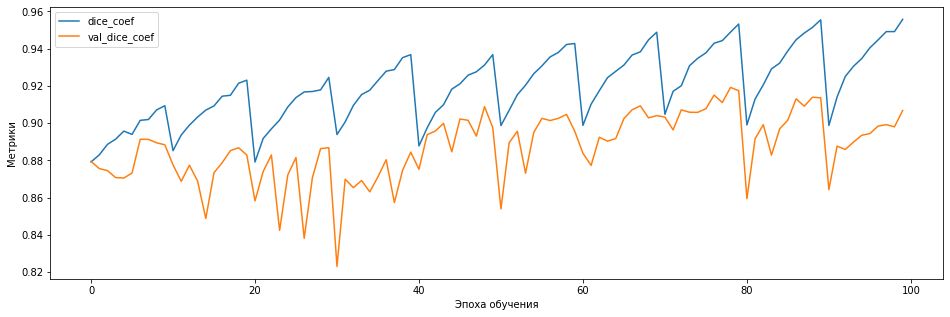

Максимальная точность val_dice_coef = 0.9192 на эпохе 78.


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: history, history_list, modelUnet
  warnings.warn(message)


In [82]:
#!g1.1
#Отображаем график точности в процессе обучения
history_acc = []
history_val = []
for N in range(len(history_list)):
    history_acc = history_acc + history_list[N].history['dice_coef']
    history_val = history_val + history_list[N].history['val_dice_coef']

plt.figure(figsize=(16,5))
plt.plot(history_acc, 
         label='dice_coef')
plt.plot(history_val, 
         label='val_dice_coef')
plt.xlabel('Эпоха обучения')
plt.ylabel('Метрики')
plt.legend()
plt.show()

# Максимальная точность
val_acc = np.array(history_val)
print('Максимальная точность val_dice_coef = {} на эпохе {}.'.format(round(val_acc.max(),4), val_acc.argmax()))
